# Práctica Final: Clasificación de Documentos con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación de documentos. El objetivo es construir un modelo capaz de clasificar automáticamente documentos en categorías predefinidas.

Pasos a seguir:

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

In [ ]:
!pip install mlflow

In [ ]:
!pip install scikit-learn

In [ ]:
! pip install apache-beam

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import os


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from mlflow.tracking import MlflowClient
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import mlflow.pyfunc
import json
import apache_beam as beam

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gcsfs

from nltk.stem import SnowballStemmer


#Carga datos!

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [ ]:
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['target'] = cancer['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


#Analisis exploratorio

In [ ]:
df.shape

(569, 31)

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
print("Nombres de las clases:", cancer.target_names)

Nombres de las clases: ['malignant' 'benign']


In [ ]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [ ]:
print("Descripción del dataset:\n", cancer.DESCR)

Descripción del dataset:
 .. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For inst

In [ ]:
# Distribución de las clases
unique, counts = np.unique(cancer.target, return_counts=True)
class_distribution = dict(zip(cancer.target_names, counts))
print("Distribución de las clases:", class_distribution)

Distribución de las clases: {'malignant': 212, 'benign': 357}


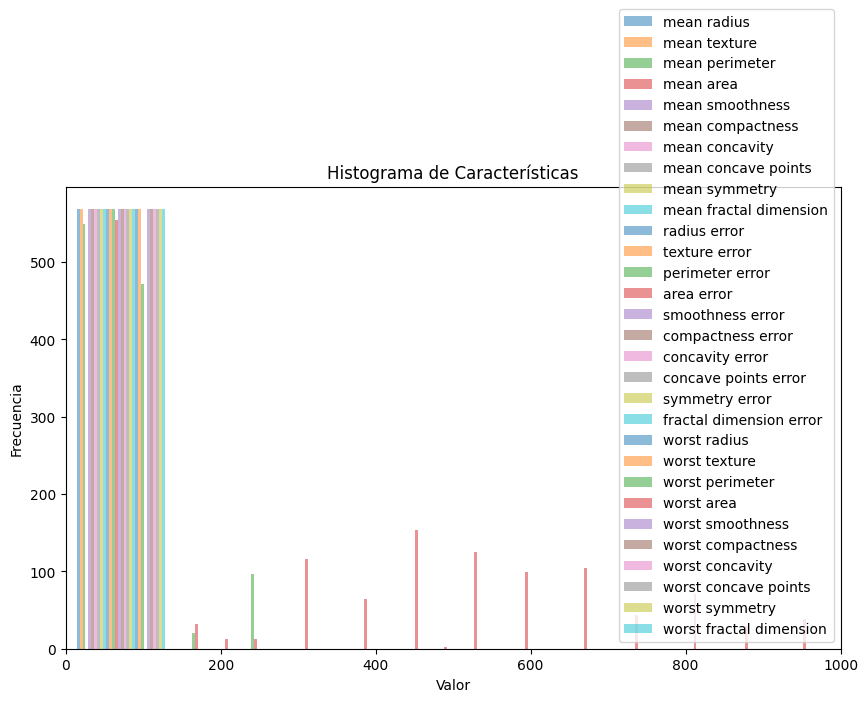

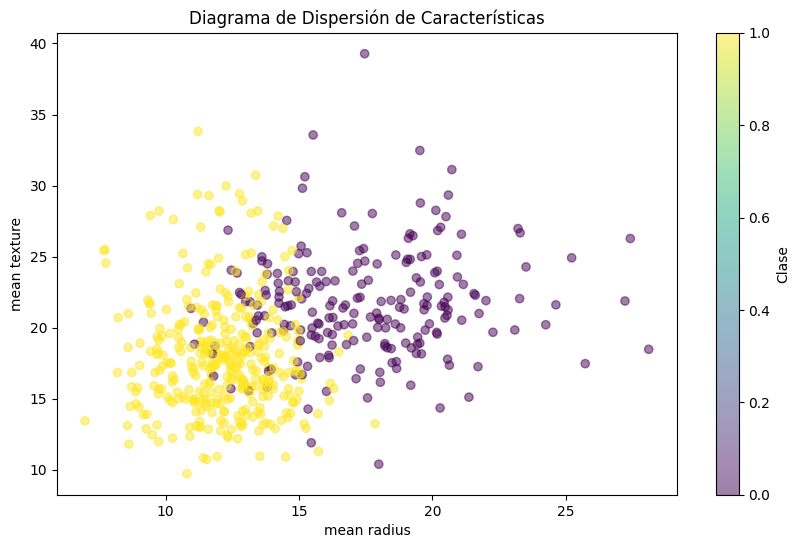

In [ ]:
import matplotlib.pyplot as plt# Histograma de las características
plt.figure(figsize=(10, 6))
plt.hist(cancer.data, bins=30, alpha=0.5)
plt.title("Histograma de Características")
plt.xlabel("Valor")
plt.xlim(0, 1000)
plt.ylabel("Frecuencia")
plt.legend(cancer.feature_names)
plt.show()

# Diagrama de dispersión de las características
plt.figure(figsize=(10, 6))
plt.scatter(cancer.data[:, 0], cancer.data[:, 1], c=cancer.target, cmap='viridis', alpha=0.5)
plt.title("Diagrama de Dispersión de Características")
plt.xlabel(cancer.feature_names[0])
plt.ylabel(cancer.feature_names[1])
plt.colorbar(label='Clase')
plt.show()

#División Train,Test

In [ ]:
train, test = train_test_split(df,test_size=0.2)

In [ ]:
test_target = test['target']
test[['target']].to_csv('test-target.csv', index = False)
del test['target']
test.to_csv('test.csv', index=False)

In [ ]:
features = [x for x in list(train.columns) if x != 'target']

In [ ]:
x_raw =train[features]
y_raw = train['target']

x_train,x_test,y_train,y_test = train_test_split(x_raw,y_raw, test_size=.20,random_state = 123,stratify=y_raw)

#Entrenamiento del modelo

In [ ]:
estimadores = 6
clf = RandomForestClassifier(n_estimators=estimadores,
                             min_samples_leaf=2,
                             class_weight='balanced',
                             random_state = 123)
preprocess =  Pipeline(steps=[('scaler',StandardScaler())])

model= Pipeline(steps= [('preprocess',preprocess),('RandomForestClassifier',clf)])

In [ ]:
model.fit(x_train,y_train)

Pipeline(steps=[('preprocess', Pipeline(steps=[('scaler', StandardScaler())])),
                ('RandomForestClassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, n_estimators=6,
                                        random_state=123))])

#Revisión de Métricas

In [ ]:
# Accuracy
accuracy_train = model.score(x_train,y_train)
print("Accuracy Train:", accuracy_train)
#score
score = model.score(x_test,y_test)
print("Score del Modelo:", score)


Accuracy Train: 0.989010989010989
Score del Modelo: 0.978021978021978


#MLFlow

In [ ]:
!pip install pyngrok

In [ ]:
mlflow.set_experiment('Practica_IA')
with mlflow.start_run(run_name='Despliegue IA'):
  mlflow.log_param('n_estimators',estimadores)
  mlflow.log_metric('accuracy',accuracy_train)
  mlflow.log_metric('score', score)

get_ipython().system_raw('mlflow ui --port 5000 &')

from pyngrok import ngrok

ngrok.kill()
NGROK_AUTH_TOKEN ='2ds49GDIE3qXW787sE74612hIsq_3RA4xRbvgzEbK9aRiZSGC'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr='5000',proto='http',bind_tls=True)
print('El tracking UI:',ngrok_tunnel.public_url)

2024/04/06 09:02:09 INFO mlflow.tracking.fluent: Experiment with name 'Practica_IA' does not exist. Creating a new experiment.


El tracking UI: https://5712-34-72-95-219.ngrok-free.app



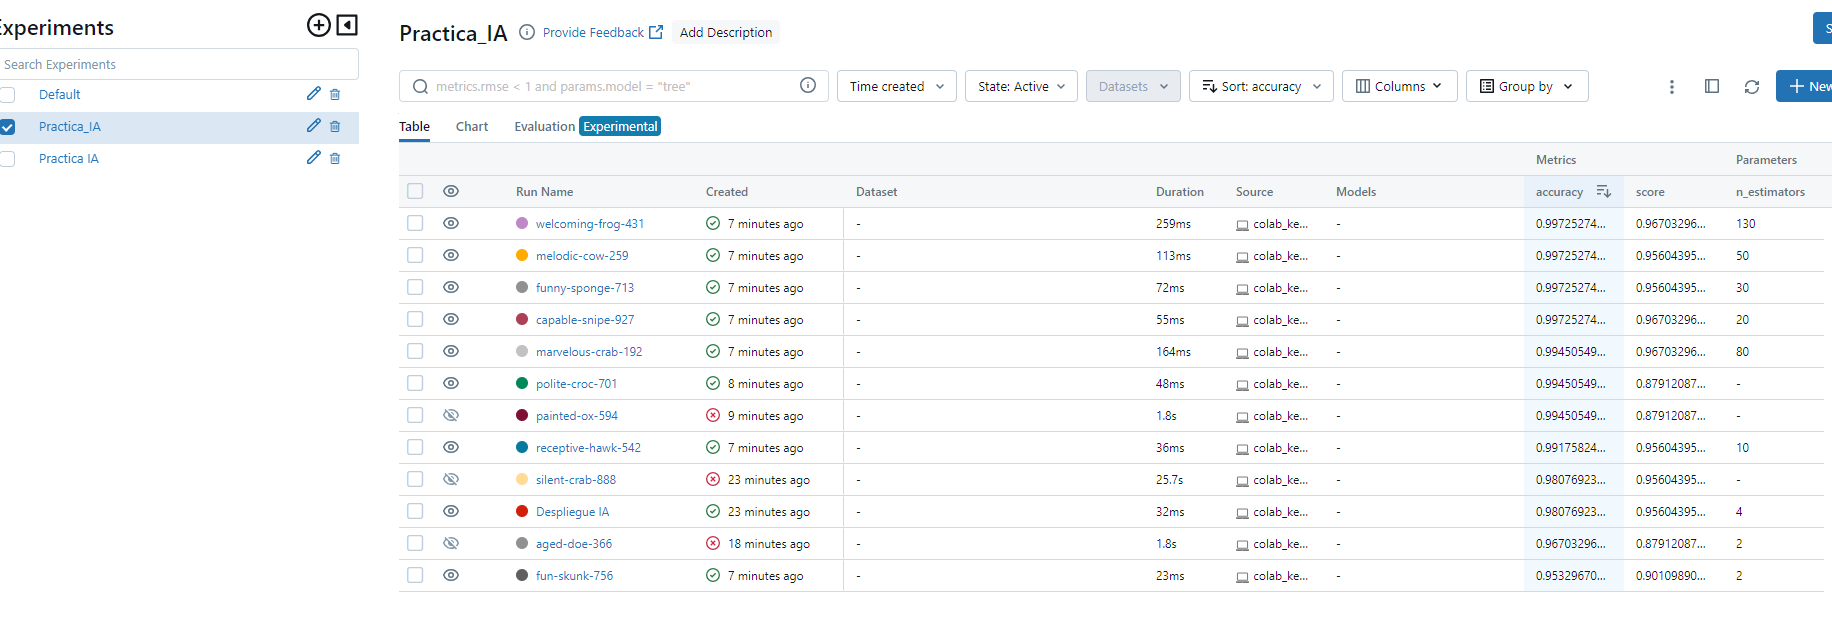

In [ ]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

In [ ]:
model_name ='clf_model'

In [ ]:
with mlflow.start_run() as run:
  run_num = run.info.run_id
  model_uri = 'runs:/{run_id}/artifact_path'.format(run_id=run_num,artifact_path= model_name)
  mlflow.log_metric('accuracy',accuracy_train)
  mlflow.log_metric('score', score)
  #mlflow.sklearn.log_model(model,model_name)

  model_details = mlflow.register_model(
      model_uri=model_uri,
      name = model_name
  )


Successfully registered model 'clf_model'.
Created version '1' of model 'clf_model'.


In [ ]:
model_version_infos = client.search_model_versions("name = '%s'" % model_name)

In [ ]:
new_model_version =max([model_version_info.version for model_version_info in  model_version_infos])

In [ ]:
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

def wait_model_transition(model_name, model_version, stage):
  client = MlflowClient()
  for _ in range(10):
    model_version_details = client.get_model_version(
      name=model_name,
      version=model_version,
    )
    status = ModelVersionStatus.from_string(model_version_details.status)
    print("Model status: %s" % ModelVersionStatus.to_string(status))
    if status == ModelVersionStatus.READY:
      client.transition_model_version_stage(
          name=model_name,
          version=model_version,
          stage=stage,
        )
      break
    time.sleep(1)

In [ ]:
try:
  wait_model_transition(model_name, int(new_model_version)-1, "None")
except:
  pass

wait_model_transition(model_name, new_model_version, "Staging")

Model status: READY


<ipython-input-28-00287e974e80>:13: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [ ]:
new_model_version

1

In [ ]:
client.update_model_version(
  name=model_name,
  version=new_model_version,
  description="Modelo random fores para el dataset de cancer de sklearn."
)

<ModelVersion: aliases=[], creation_timestamp=1712394130974, current_stage='Staging', description='Modelo random fores para el dataset de cancer de sklearn.', last_updated_timestamp=1712394131081, name='clf_model', run_id='c722d5db75944096a456fc8601669495', run_link=None, source='file:///content/mlruns/326471840578824123/c722d5db75944096a456fc8601669495/artifacts/artifact_path', status='READY', status_message=None, tags={}, user_id=None, version=1>

#Este sería el script completo:

In [ ]:
'''
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import subprocess
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

# Load breast cancer dataset
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df['target'] = cancer['target']

# Split data into train and test sets
train, test = train_test_split(df, test_size=0.2)
test_target = test['target']
test[['target']].to_csv('test-target.csv', index=False)
del test['target']
test.to_csv('test.csv', index=False)

features = [x for x in list(train.columns) if x != 'target']
x_raw = train[features]
y_raw = train['target']
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw,
                                                    test_size=.20,
                                                    random_state=123,
                                                    stratify=y_raw)

n_stimators = [2, 10, 20, 30, 50, 80, 130]

# Launch MLflow UI asynchronously
mlflow_ui_process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

# Delay to allow MLflow UI to start
time.sleep(5)
mlflow.set_experiment('Practica_IA')
for i in n_stimators:
    with mlflow.start_run() as run:
        print(f"Running for n_estimators = {i}")
        clf = RandomForestClassifier(n_estimators=i,
                                     min_samples_leaf=2,
                                     class_weight='balanced',
                                     random_state=123)
        preprocessor = Pipeline(steps=[('scaler', StandardScaler())])
        model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('randomforestclassifier', clf)])
        model.fit(x_train, y_train)
        accuracy = model.score(x_train, y_train)
        score = model.score(x_test, y_test)

        # Log metrics and parameters for each run
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('score', score)
        mlflow.log_param("n_estimators", i)'''


# Práctica Final: detección de mensajes troll



En los últimos años Twitch se ha consolidad como uno de los principales medios de comunicación especialmente para las generaciones más jóvenes.

Al tratarse de una plataforma participativa en la que los usuarios pueden poner comentarios durante y posteriormente a las emisiones. Entre estos comentarios han aparecido como siempre comentarios ofensisvos.

En esta práctica construiremos una Inteligencia Artificial capaz de clasificar esos mensajes troll.

Durante la práctica entrenaremos el modelo de Deep Learning y lo desplegaremos para inferencia en batch, la más habitual actualmente dentro de la industria:

## Teoría

**1. ¿Qué es Apache Beam?**

Apache Beam es un framework de trabajo que permite definir pipelines de procesado de datos enfocadas a la paralelización de procesos.

Beam es una abstracción por lo que los detalles de implementación son gestionados por los motores de ejecución (Flink, DataFlow...)

Es un framework compatible con distintos lenguajes de programación como Java, Python o Go.

**2. ¿Cuáles son las diferentes formas de desplegar un modelo?**

Distinguimos cuatro opciones:

* Despligue en Batch. Desplegamos el modelo para hacer predicciones de grandes cantidades de datos en un momento puntual.

* Despligue online. Permite la disponibilización del modelo a demanda por el ususario de manera que se pueden realizar predicciones mediante llamdas a APIs.

* Despliegue en streaming Despligue pensando en la recepción continua de datos de manera que nuestro servidor es capaz de procesar un flujo continuo e ininterrumpido de datos en tiempo real.

* ML Automatizado. Es el estado más avanzado en el desarrollo de MLOPS en el que el modelo es monitoeado y reentrenado de manera automática.

**3. ¿Cuál es la principal diferencia entre la inferencia en batch y la inferencia en streaming?**

La inferencia en batch procesa grandes cantidades de datos en momentos puntuales y normalmente programados de antemano frente al procesamiento en streming cuya infrastructura está diseñada para estar constantemente en funcionamiento emitiendo predicciones de manera continua y en tiempo real (o casi).



# Configuración de nuestro proyecto en GCP


In [ ]:
PROJECT_ID = "bold-ethos-417621" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


Creamos el bucket mediante la consola y una vez creado lo indicamos en la variable:

In [ ]:
BUCKET_NAME = "practica-imple-algos" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [ ]:
#! gsutil mb -l $REGION gs://$BUCKET_NAME

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

   2756023  2024-04-05T18:52:50Z  gs://practica-imple-algos/Dataset for Detection of Cyber-Trolls.json#1712343170452301  metageneration=1
TOTAL: 1 objects, 2756023 bytes (2.63 MiB)


# Entrenamiento e inferencia en Batch

## Preparación

Para esta primera parte se va a utilizar [Tweets Dataset for Detection of Cyber-Trolls](https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls). El objetivo es desarrollar un clasificador binario para detectar si el mensaje recibido es troll (1) o no (0). **Las métricas obtenidas del entrenamiento y la inferencia no se tendrán en cuenta para la evaluación de la práctica, la importancia está en la arquitectura de la solución**, es decir, lo importante no es que nuestro modelo detecte correctamente los tweets de trolls si no que funcione y sea capaz de hacer inferencias.


A continuación, se van a subir los datos de entrenamiento al bucket del proyecto que se haya creado. **Importante:** crea el bucket en una única región. Os dejo disponibilizado el dataset en un bucket de acceso público:

In [ ]:
%pip install gdown
! gdown "1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr"

Downloading...
From: https://drive.google.com/uc?id=1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr
To: /content/twitter-cyber-trolls/dataset-cybertrolls.json
100% 2.76M/2.76M [00:00<00:00, 172MB/s]


Ahora se crea el directorio dónde vas a desarrollar esta primera parte de la práctica.

In [ ]:
directorio = '/content/twitter-cyber-trolls'
os.makedirs(directorio, exist_ok=True)


In [ ]:
WORK_DIR = 'gs://' + 'practica-imple-algos' + '/twitter-cyber-trolls'

Se establece el directorio de trabajo que hemos creado.

In [ ]:
import os
current_directory = os.getcwd()
print("El directorio actual es:", current_directory)

El directorio actual es: /content/twitter-cyber-trolls


In [ ]:
%cd twitter-cyber-trolls

[Errno 2] No such file or directory: 'twitter-cyber-trolls'
/content/twitter-cyber-trolls


In [ ]:
!ls


dataset-cybertrolls.json  requirements.txt


In [ ]:
PROJECT_ID = "bold-ethos-417621" #@param {type:"string"}
! gcloud config set project $PROJECT_ID
BUCKET_NAME = "practica-imple-algos" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Bucket: {BUCKET_NAME}")

Updated property [core/project].
Project: bold-ethos-417621
Region: europe-west1
Bucket: practica-imple-algos


Ahora se descargarán los datos en el workspace de Colab para trabajar en local.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se establecen las dependencias que se usarán en la práctica. Se pueden añadir y quitar las dependencias que no se usen o viceversa.

In [ ]:
%%writefile requirements.txt

apache-beam[gcp]
tensorflow
gensim==3.6.0
fsspec==0.8.4
gcsfs==0.7.1
numpy==1.20.0

Overwriting requirements.txt


Instalamos las dependencias. **No olvides reiniciar el entorno al instalar y establecer las variables y credenciales de GCP al arrancar.**

In [ ]:
! pip install -r requirements.txt

  Using cached gensim-3.6.0-cp310-cp310-linux_x86_64.whl
  Using cached fsspec-0.8.4-py3-none-any.whl (91 kB)
  Using cached gcsfs-0.7.1-py2.py3-none-any.whl (20 kB)
  Using cached numpy-1.20.0.zip (8.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.1.1-py3-none-any.whl (1.1 MB)
  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB

In [ ]:
! pip install apache-beam[gcp]

## Primer ejercicio

Desarrollar un pipeline de preprocesamiento utilizando Apache Beam para generar datos de train, eval y test para los datos proporcionados anteriormente. Requisitos:

- Proporcionar dos modos de ejecución: `train` y `test`
- Soportar ejecuciones en local con `DirectRunner` y ejecuciones en Dataflow usando `DataFlowRunner`.

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

with beam.Pipeline(options=PipelineOptions()) as pipeline:
  pass

In [ ]:
'''
%%writefile preprocess.py

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

class PreprocessData(beam.DoFn):
    def preprocess_text(text):
        content = text.get('content', '')
        label = text['annotation']['label'][0] if 'annotation' in text and 'label' in text['annotation'] else None
        return {'content': content, 'label': label}

def run_preprocessing(input_file, output_file):
    # Configurar las opciones del pipeline
    options = PipelineOptions()

    # Crear el pipeline
    with beam.Pipeline() as pipeline:
        tweets = (
            pipeline
            | 'ReadInput' >> beam.io.ReadFromText('gs://practica-imple-algos/Dataset for Detection of Cyber-Trolls.json' )
            | 'ParseJSON' >> beam.Map(json.loads)
            | 'PreprocessTweets' >> beam.Map(preprocess_text)
        )

        # Aplicar preprocesamiento
        preprocessed_tweets = tweets | 'MyPreprocessTweets' >> beam.ParDo(PreprocessData())

        # Escribir los datos preprocesados en un archivo de salida
        preprocessed_tweets | 'WriteOutput' >> beam.io.WriteToText(output_file)

if __name__ == '__main__':
    input_file = 'gs://practica-imple-algos/Dataset for Detection of Cyber-Trolls.json'  # Nombre del archivo de entrada
    output_file = 'output.txt'  # Nombre del archivo de salida
    run_preprocessing(input_file, output_file)'''

In [ ]:
'''%%writefile preprocess.py

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import json

class PreprocessData(beam.DoFn):
    def process(self, text):
        content = text.get('content', '')
        label = text['annotation']['label'][0] if 'annotation' in text and 'label' in text['annotation'] else None
        return [{'content': content, 'label': label}]

def run_preprocessing(input_file, output_file):
    # Configurar las opciones del pipeline
    options = PipelineOptions()

    # Crear el pipeline
    with beam.Pipeline(options=options) as pipeline:
        tweets = (
            pipeline
            | 'ReadInput' >> beam.io.ReadFromText(input_file)
            | 'ParseJSON' >> beam.Map(json.loads)
            | 'PreprocessTweets' >> beam.ParDo(PreprocessData())
        )

        # Escribir los datos preprocesados en un archivo de salida
        tweets | 'WriteOutput' >> beam.io.WriteToText(output_file)

if __name__ == '__main__':
    input_file = 'gs://practica-imple-algos/Dataset for Detection of Cyber-Trolls.json'  # Nombre del archivo de entrada
    output_file = 'output.txt'  # Nombre del archivo de salida
    run_preprocessing(input_file, output_file)'''

Writing preprocess.py


In [ ]:
%%writefile preprocess.py

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import json
import re
from nltk.corpus import stopwords  # Importar stopwords desde nltk
from nltk.stem import SnowballStemmer

import nltk
nltk.download('stopwords')

STOP_WORDS = stopwords.words("english")
STEMMER = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
class PreprocessData(beam.DoFn):
    def process(self, text):
        content = text.get('content', '')
        label = text['annotation']['label'][0] if 'annotation' in text and 'label' in text['annotation'] else None
        processed_content = self.process_text(content)  # Procesar el texto
        return [{'content': processed_content, 'label': label}]

    def process_text(self, text):
        # Remove link, user, and special characters
        stem = False
        text = re.sub(TEXT_CLEANING_RE, " ", str(text).lower()).strip()
        tokens = []
        for token in text.split():
            if token not in STOP_WORDS:
                if stem:
                    tokens.append(STEMMER.stem(token))
                else:
                    tokens.append(token)
        return " ".join(tokens)

def run_preprocessing(input_file, output_file_gcs, output_file_local):
    # Configurar las opciones del pipeline
    options = PipelineOptions()

    # Crear el pipeline
    with beam.Pipeline(options=options) as pipeline:
        tweets = (
            pipeline
            | 'ReadInput' >> beam.io.ReadFromText(input_file)
            | 'ParseJSON' >> beam.Map(json.loads)
            | 'PreprocessTweets' >> beam.ParDo(PreprocessData())
        )
        # Escribir los datos preprocesados en un archivo de salida en Google Cloud Storage
        tweets | 'WriteOutputGCS' >> beam.io.WriteToText(output_file_gcs, num_shards=1, shard_name_template='')

        # Escribir los datos preprocesados en un archivo de salida en el sistema local
        tweets | 'WriteOutputLocal' >> beam.io.WriteToText(output_file_local, num_shards=1, shard_name_template='')

if __name__ == '__main__':
    input_file = 'gs://practica-imple-algos/Dataset for Detection of Cyber-Trolls.json'  # Nombre del archivo de entrada
    output_file_gcs = 'gs://practica-imple-algos/dataset-cybertrolls_processed.json'  # Nombre del archivo de salida en GCS
    output_file_local = '/content/twitter-cyber-trolls/dataset-cybertrolls_processed.json'  # Nombre del archivo de salida local
    run_preprocessing(input_file, output_file_gcs, output_file_local)

Overwriting preprocess.py


Se proporciona un fichero `setup.py` necesario para ejecutar en DataFlow. Modificar la variable `REQUIRED_PACKAGES` con las dependencias que se hayan usado en el `requirements.txt`

In [ ]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
  "apache-beam[gcp]==2.24.0",
  "tensorflow==2.8.0",
  "gensim==3.6.0",
  "fsspec==0.8.4",
  "gcsfs==0.7.1",
  "numpy==1.20.0"
]

setuptools.setup(
    name="twitchstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Troll detection",
)


Writing setup.py


Me creo una copia por si hubiera algún error en el procesamiento (buena práctica):

In [ ]:
! gdown "1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr"
! gsutil cp dataset-cybertrolls.json gs://$WORK_DIR/data.json


Downloading...
From: https://drive.google.com/uc?id=1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr
To: /content/twitter-cyber-trolls/dataset-cybertrolls.json
100% 2.76M/2.76M [00:00<00:00, 111MB/s]
BucketNotFoundException: 404 gs://gs: bucket does not exist.


In [ ]:
import os
WORK_DIR = os.getcwd()

In [ ]:
WORK_DIR

'/content/twitter-cyber-trolls'

In [ ]:
!ls


dataset-cybertrolls.json   requirements.txt  test_data.json   trainer
output.txt-00000-of-00001  setup.py	     train_data.csv   val_data.csv
preprocess.py		   test_data.csv     train_data.json  val_data.json


### Validación preprocess train en local
Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en local.

In [ ]:
!python3 preprocess.py \
  --input "gs://practica-imple-algos/Dataset for Detection of Cyber-Trolls.json" \
  --output gs://practica-imple-algos/dataset-cybertrolls_processed.json


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!ls


dataset-cybertrolls.json			   preprocess.py     test_data.json   val_data.csv
dataset-cybertrolls_processed.json		   requirements.txt  train_data.csv   val_data.json
dataset-cybertrolls_processed.json-00000-of-00001  setup.py	     train_data.json
output.txt-00000-of-00001			   test_data.csv     trainer


In [ ]:
import ast
from sklearn.model_selection import train_test_split

dataset = []
with open('/content/twitter-cyber-trolls/dataset-cybertrolls_processed.json') as file:
    for line in file:
        data = ast.literal_eval(line)
        # Aplicar preprocesamiento al contenido del texto
        data['content'] = data['content']
        # Agregar el objeto JSON preprocesado a la lista
        dataset.append(data)

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [ ]:
import pandas as pd

# Convertir a DataFrame
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Guardar en CSV
train_df.to_json('/content/twitter-cyber-trolls/train_data.json', orient='records', lines=True)
val_df.to_json('/content/twitter-cyber-trolls/val_data.json', orient='records', lines=True)
test_df.to_json('/content/twitter-cyber-trolls/test_data.json', orient='records', lines=True)

In [ ]:
from google.colab import auth
from google.cloud import storage

# Autenticar con Google Cloud
auth.authenticate_user()

# Crear un cliente de Cloud Storage
client = storage.Client()

# Nombre del bucket y la ruta en GCS
bucket_name = 'practica-imple-algos'
blob_path = 'twitter-cyber-trolls/'

# Subir los archivos al bucket en GCS
for filename in ['train_data.json', 'val_data.json', 'test_data.json']:
    blob = client.bucket(bucket_name).blob(blob_path + filename)
    with open('/content/twitter-cyber-trolls/' + filename, 'rb') as f:
        blob.upload_from_file(f)
    print(f'{filename} subido exitosamente a {blob_path}{filename}')

train_data.json subido exitosamente a twitter-cyber-trolls/train_data.json
val_data.json subido exitosamente a twitter-cyber-trolls/val_data.json
test_data.json subido exitosamente a twitter-cyber-trolls/test_data.json


In [ ]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/train_data.json \
  --output $WORK_DIR/transformed_data \
  --mode train



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Validación preprocess test en local

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en local.

In [ ]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/test_data.json \
  --output $WORK_DIR/data/transformed_data \
  --mode test

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Segundo ejercicio

Desarrollar una tarea de entrenamiento para los datos preprocesados. Requisitos:

- Soportar ejecuciones en local usando el SDK de AI-Platform y ejecuciones en GCP con el mismo código.

Se crea el directorio donde trabajaremos:

In [ ]:
#%mkdir /content/batch/trainer

mkdir: cannot create directory ‘/content/batch/trainer’: No such file or directory


In [ ]:
%mkdir -p trainer

In [ ]:
%%writefile trainer/__init__.py

version = "0.1.0"

Writing trainer/__init__.py


In [ ]:
%%writefile trainer/__init__.py
version = "0.1.0"
import os
import numpy as np
import pandas as pd

class PreprocessedDataTrainer:
    def __init__(self):
        self.model = None

    def train(self, train_data):
        # Lógica de entrenamiento del modelo
        # Aquí puedes utilizar cualquier algoritmo de aprendizaje automático
        # Por ejemplo, podrías usar una regresión logística, una red neuronal, etc.
        pass

    def evaluate(self, test_data):
        # Lógica de evaluación del modelo
        # Aquí evalúas el rendimiento del modelo entrenado utilizando los datos de prueba
        pass

if __name__ == '__main__':
    # Definir las rutas de los datos de entrada y salida
    local_train_data_path = '/content/twitter-cyber-trolls/train_data.json'
    local_test_data_path = '/content/twitter-cyber-trolls/test_data.json'
    gcs_train_data_path = 'gs://practica-imple-algos/twitter-cyber-trolls/train_data.json'
    gcs_test_data_path = 'gs://practica-imple-algos/twitter-cyber-trolls/test_data.json'
    local_output_path = '/content/twitter-cyber-trolls/'
    gcs_output_path = 'gs://practica-imple-algos/twitter-cyber-trolls/'

    # Cargar los datos preprocesados
    train_data = pd.read_json(local_train_data_path)
    test_data = pd.read_json(local_test_data_path)

    # Inicializar el entrenador y entrenar el modelo
    trainer = PreprocessedDataTrainer()
    trainer.train(train_data)

    # Evaluar el modelo entrenado
    evaluation_result = trainer.evaluate(test_data)

    # Guardar el modelo entrenado en local (opcional)
    # Si deseas guardar el modelo entrenado para su uso posterior, puedes hacerlo aquí
    # Por ejemplo, puedes utilizar la biblioteca joblib o pickle para guardar el modelo en un archivo

    # Imprimir los resultados de la evaluación (opcional)
    print('Resultado de la evaluación:', evaluation_result)

    # Guardar los resultados de la evaluación en local
    evaluation_result.to_json(os.path.join(local_output_path, 'evaluation_result.json'))


    evaluation_result.to_json(os.path.join(gcs_output_path, 'evaluation_result.json'))

Overwriting trainer/__init__.py


### Validación Train en local

Con el comando mostrado a continuación se valida el correcto entrenamiento del modelo usando los datos preprocesados del apartado anterior.

In [ ]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  -- \
  --work-dir $WORK_DIR \
  --epochs 1

Updated property [ml_engine/local_python].
/usr/bin/python3: No module named trainer.task


In [ ]:
!python3 trainer/__init__.py

Traceback (most recent call last):
  File "/content/twitter-cyber-trolls/trainer/__init__.py", line 31, in <module>
    train_data = pd.read_json(local_train_data_path)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/json/_json.py", line 784, in read_json
    return json_reader.read()
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/json/_json.py", line 975, in read
    obj = self._get_object_parser(self.data)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/json/_json.py", line 1001, in _get_object_parser
    obj = FrameParser(json, **kwargs).parse()
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/json/_json.py", line 1134, in parse
    self._parse()
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/json/_json.py", line 1320, in _parse
    loads(json, precise_float=self.precise_float), dtype=None
ValueError: Trailing data


## Tercer ejercicio

Desarrollar un pipeline de inferencia utilizando Apache Beam para generar predicciones usando los modelos generados en el apartado anterior así como los datos de test generados en el primer ejercicio.


In [ ]:

def load_model(model_path):
    # Carga tu modelo entrenado
    # Ejemplo: model = tf.keras.models.load_model(model_path)
    pass

def predict(model, instance):
    # Haz la predicción utilizando el modelo cargado
    # Ejemplo: prediction = model.predict(instance)
    pass

def inference_pipeline(input_file, output_file, model_path):
    # Carga el modelo
    model = load_model(model_path)

    # Configura las opciones del pipeline
    pipeline_options = PipelineOptions()

    # Define el pipeline de Apache Beam
    with beam.Pipeline(options=pipeline_options) as pipeline:
        predictions = (
            pipeline
            | 'ReadInput' >> beam.io.ReadFromText(input_file)
            | 'ParseJSON' >> beam.Map(json.loads)
            | 'Predict' >> beam.Map(lambda instance: (instance['id'], predict(model, instance)))
            | 'FormatOutput' >> beam.Map(lambda tup: json.dumps({'id': tup[0], 'prediction': tup[1]}))
            | 'WriteOutput' >> beam.io.WriteToText(output_file)
        )

if __name__ == '__main__':
    input_file = 'gs://practica-imple-algos/twitter-cyber-trolls/train_data.json'
    output_file = 'gs://practica-imple-algos/twitter-cyber-trolls/predictions.json'
    model_path = 'gs://practica-imple-algos/twitter-cyber-trolls/model.h5'

    inference_pipeline(input_file, output_file, model_path)

ERROR:apache_beam.runners.common:json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0) [while running 'ParseJSON']
Traceback (most recent call last):
  File "apache_beam/runners/common.py", line 1435, in apache_beam.runners.common.DoFnRunner.process
  File "apache_beam/runners/common.py", line 637, in apache_beam.runners.common.SimpleInvoker.invoke_process
  File "/usr/local/lib/python3.10/dist-packages/apache_beam/transforms/core.py", line 1961, in <lambda>
    wrapper = lambda x, *args, **kwargs: [fn(x, *args, **kwargs)]
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


RuntimeError: json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0) [while running 'ParseJSON']

Generamos un timestamp para la ejecución de las predicciones

In [ ]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [ ]:
TIMESTAMP

### Validación Predict en local

Con el comando mostrado a continuación se valida la correcta inferencia usando los modelos anteriores y los datos de test generados anteriormente.

# Mensaje final

¡Muchas gracias por participar en este curso, espero que tanto las sesiones teóricas como la práctica te hayan resultado útiles. A lo largo de esta semmana iréis recibiendo feedback personalizado sobre vuestras prácticas.

¡Muchas gracias y ánimo con el proyecto final!